In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import adfuller, coint

In [2]:
file_path = Path("round-4-island-data-bottle")

In [3]:
if file_path.exists():
    # Read the CSV file
    df_day_1 = pd.read_csv(
        file_path / "trades_round_4_day_1_nn.csv", delimiter=";"
    )  # day 0
    df_day_2 = pd.read_csv(
        file_path / "trades_round_4_day_2_nn.csv", delimiter=";"
    )  # day 1
    df_day_3 = pd.read_csv(
        file_path / "trades_round_4_day_3_nn.csv", delimiter=";"
    )  # day 2
    print("File loaded successfully.")
else:
    print("File not found. Please ensure the file exists at:", file_path)

df_day_1["timestamp"] = pd.to_numeric(df_day_1["timestamp"])
df_day_2["timestamp"] = pd.to_numeric(df_day_2["timestamp"])
df_day_3["timestamp"] = pd.to_numeric(df_day_3["timestamp"])

df_day_3["timestamp"] += len(df_day_1["timestamp"]) + len(df_day_2["timestamp"])
df_day_2["timestamp"] += len(df_day_1["timestamp"])
df = pd.concat([df_day_1, df_day_2, df_day_3], ignore_index=True)

File loaded successfully.


In [4]:
df.head(10)

,timestamp,buyer,seller,symbol,currency,price,quantity
0,800,NaN,NaN,COCONUT_COUPON,SEASHELLS,636.0,5
1,900,NaN,NaN,COCONUT_COUPON,SEASHELLS,634.0,17
2,1100,NaN,NaN,COCONUT_COUPON,SEASHELLS,635.0,17
3,1900,NaN,NaN,COCONUT_COUPON,SEASHELLS,635.0,16
4,2000,NaN,NaN,COCONUT_COUPON,SEASHELLS,637.0,14
5,3000,NaN,NaN,COCONUT_COUPON,SEASHELLS,631.0,6
6,3900,NaN,NaN,COCONUT_COUPON,SEASHELLS,635.0,2
7,3900,NaN,NaN,COCONUT_COUPON,SEASHELLS,635.0,10
8,4200,NaN,NaN,COCONUT_COUPON,SEASHELLS,635.0,20
9,4300,NaN,NaN,COCONUT_COUPON,SEASHELLS,635.0,2


In [5]:
df.tail(10)

,timestamp,buyer,seller,symbol,currency,price,quantity
5112,997230,NaN,NaN,COCONUT,SEASHELLS,9885.0,6
5113,997530,NaN,NaN,COCONUT,SEASHELLS,9883.0,9
5114,997730,NaN,NaN,COCONUT,SEASHELLS,9885.0,3
5115,998330,NaN,NaN,COCONUT,SEASHELLS,9885.0,9
5116,998930,NaN,NaN,COCONUT,SEASHELLS,9887.0,8
5117,999630,NaN,NaN,COCONUT_COUPON,SEASHELLS,585.0,14
5118,1000530,NaN,NaN,COCONUT,SEASHELLS,9885.0,9
5119,1000630,NaN,NaN,COCONUT,SEASHELLS,9883.0,8
5120,1002030,NaN,NaN,COCONUT,SEASHELLS,9887.0,5
5121,1003230,NaN,NaN,COCONUT_COUPON,SEASHELLS,575.0,14


In [6]:
COCONUT_df = df[df["symbol"] == "COCONUT"]
COCONUT_COUPON_df = df[df["symbol"] == "COCONUT_COUPON"]
COCONUT_df_copy = COCONUT_df.copy()
COCONUT_df_copy.loc[:, "next_price"] = COCONUT_df_copy.loc[:, "price"].shift(-1)
COCONUT_df_copy.loc[:, "next_next_price"] = COCONUT_df_copy.loc[:, "price"].shift(-2)

In [7]:
COCONUT_df_copy

,timestamp,buyer,seller,symbol,currency,price,quantity,next_price,next_next_price
12,5200,NaN,NaN,COCONUT,SEASHELLS,9997.0,8,10005.0,10007.0
18,9300,NaN,NaN,COCONUT,SEASHELLS,10005.0,6,10007.0,10003.0
21,10900,NaN,NaN,COCONUT,SEASHELLS,10007.0,10,10003.0,10004.0
22,12500,NaN,NaN,COCONUT,SEASHELLS,10003.0,10,10004.0,10001.0
26,14900,NaN,NaN,COCONUT,SEASHELLS,10004.0,10,10001.0,10000.0
...,...,...,...,...,...,...,...,...,...
5115,998330,NaN,NaN,COCONUT,SEASHELLS,9885.0,9,9887.0,9885.0
5116,998930,NaN,NaN,COCONUT,SEASHELLS,9887.0,8,9885.0,9883.0
5118,1000530,NaN,NaN,COCONUT,SEASHELLS,9885.0,9,9883.0,9887.0
5119,1000630,NaN,NaN,COCONUT,SEASHELLS,9883.0,8,9887.0,NaN


In [8]:
COCONUT_price = COCONUT_df_copy[
    ["timestamp", "price", "quantity", "next_price", "next_next_price"]
]
COCONUT_COUPON_price = COCONUT_COUPON_df[["timestamp", "price", "quantity"]]

In [9]:
COCONUT_price.describe()

,timestamp,price,quantity,next_price,next_next_price
count,1.967000e+03,1967.000000,1967.000000,1966.000000,1965.000000
mean,4.975230e+05,9998.987799,6.432639,9998.988810,9998.985751
std,2.876519e+05,89.051586,2.676793,89.074231,89.096802
min,5.130000e+03,9810.000000,1.000000,9810.000000,9810.000000
25%,2.509650e+05,9913.500000,5.000000,9913.250000,9913.000000
50%,4.924150e+05,10027.000000,7.000000,10027.000000,10027.000000
75%,7.402150e+05,10077.000000,9.000000,10077.000000,10077.000000
max,1.002030e+06,10141.000000,10.000000,10141.000000,10141.000000


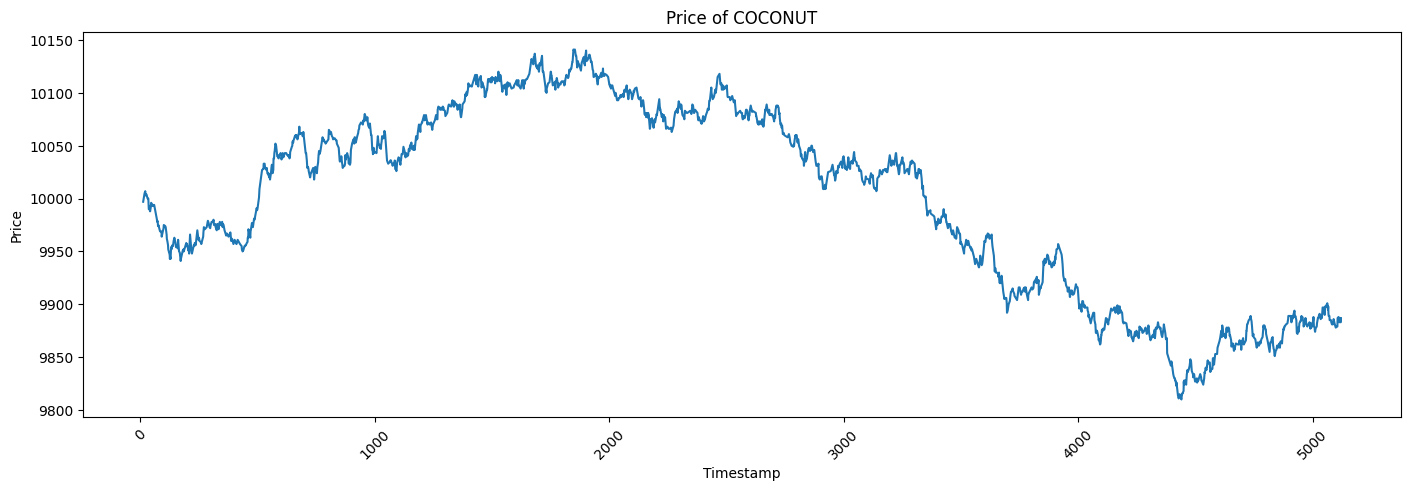

In [10]:
plt.figure(figsize=(17, 5))
# Plot the price
plt.plot(COCONUT_price["price"])
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title("Price of COCONUT")
plt.xticks(rotation=45)
plt.show()

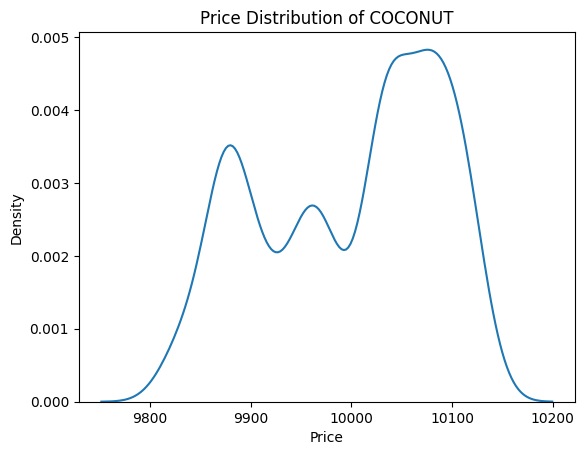

In [11]:
sns.kdeplot(COCONUT_price["price"])
plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Price Distribution of COCONUT")
plt.show()

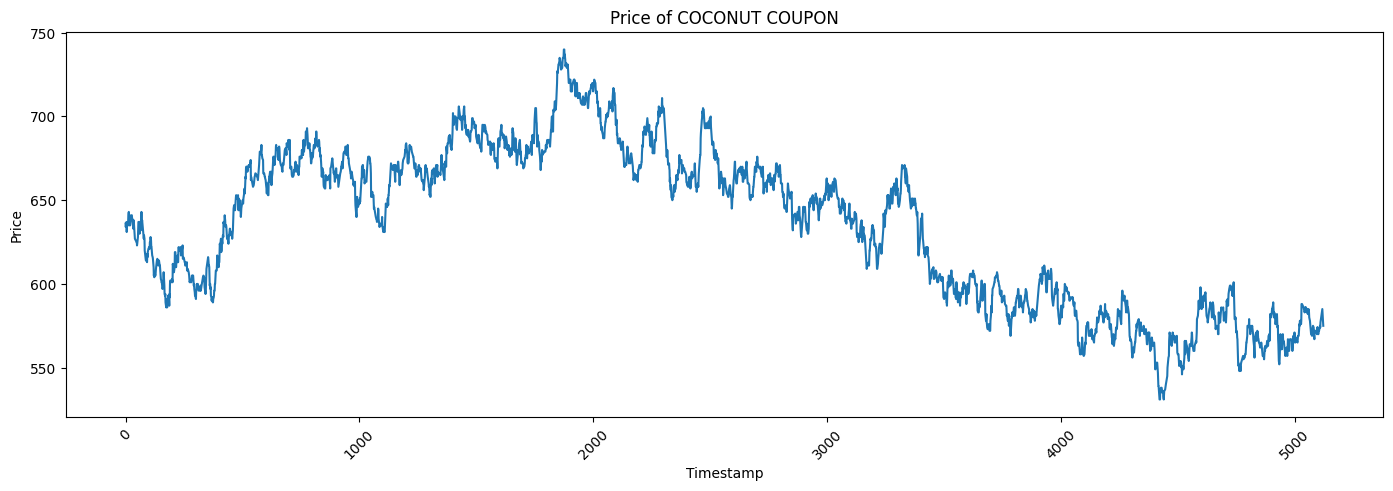

In [12]:
plt.figure(figsize=(17, 5))
# Plot the price
plt.plot(COCONUT_COUPON_price["price"])
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title("Price of COCONUT COUPON")
plt.xticks(rotation=45)
plt.show()

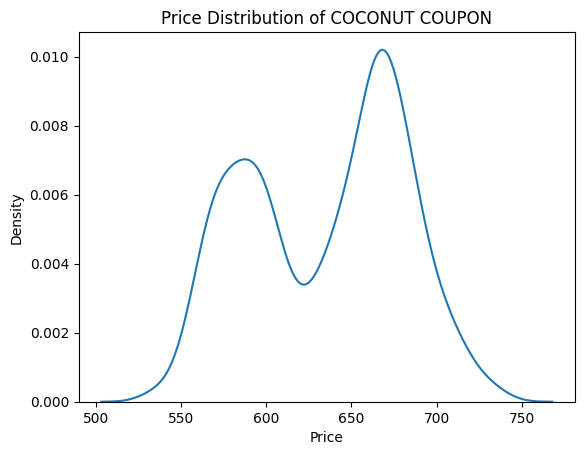

In [13]:
sns.kdeplot(COCONUT_COUPON_price["price"])
plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Price Distribution of COCONUT COUPON")
plt.show()

In [14]:
def printTestData(result):
    print(f"ADF Statistic: {result[0]}")
    print(f"n_lags: {result[1]}")
    print(f"p-value: {result[1]}")
    for key, value in result[4].items():
        print("Critial Values:")
        print(f"   {key}, {value}")
    print("\n")

In [15]:
COCONUT_ADF = adfuller(COCONUT_price["price"], autolag="AIC")
printTestData(COCONUT_ADF)

ADF Statistic: -0.5448442448911539
n_lags: 0.8829644196039411
p-value: 0.8829644196039411
Critial Values:
   1%, -3.4336822458349143
Critial Values:
   5%, -2.863011992405672
Critial Values:
   10%, -2.567553628252692




In [16]:
COCONUT_COUPON_ADF = adfuller(COCONUT_COUPON_price["price"], autolag="AIC")
printTestData(COCONUT_COUPON_ADF)

ADF Statistic: -1.872785010830393
n_lags: 0.34497018590907946
p-value: 0.34497018590907946
Critial Values:
   1%, -3.4324256840496985
Critial Values:
   5%, -2.8624571096973295
Critial Values:
   10%, -2.5672581988257397




In [17]:
COCONUT_returns = np.log(
    COCONUT_price["price"] / COCONUT_price["price"].shift(-1)
).dropna()
COCONUT_drift = np.mean(COCONUT_returns)
COCONUT_volatility = np.std(COCONUT_returns)
COCONUT_COUPON_returns = np.log(
    COCONUT_COUPON_price["price"] / COCONUT_COUPON_price["price"].shift(-1)
).dropna()
COCONUT_COUPON_drift = np.mean(COCONUT_COUPON_returns)
COCONUT_COUPON_volatility = np.std(COCONUT_COUPON_returns)
print("COCONUT_drift: ", COCONUT_drift)
print("COCONUT_volatility: ", COCONUT_volatility)
print("COCONUT_COUPON_drift: ", COCONUT_COUPON_drift)
print("COCONUT_COUPON_volatility:; ", COCONUT_COUPON_volatility)

COCONUT_drift:  5.627815396769003e-06
COCONUT_volatility:  0.0004050435799965118
COCONUT_COUPON_drift:  3.196845990576189e-05
COCONUT_COUPON_volatility:;  0.005649806062108461


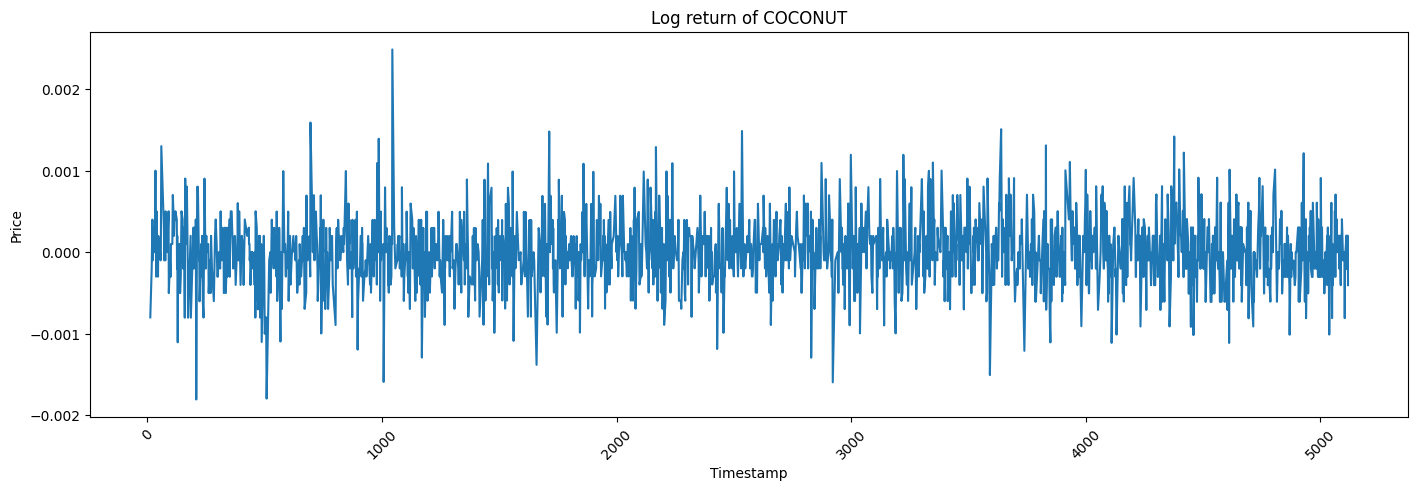

In [18]:
plt.figure(figsize=(17, 5))
# Plot the price
plt.plot(COCONUT_returns)
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title("Log return of COCONUT")
plt.xticks(rotation=45)
plt.show()

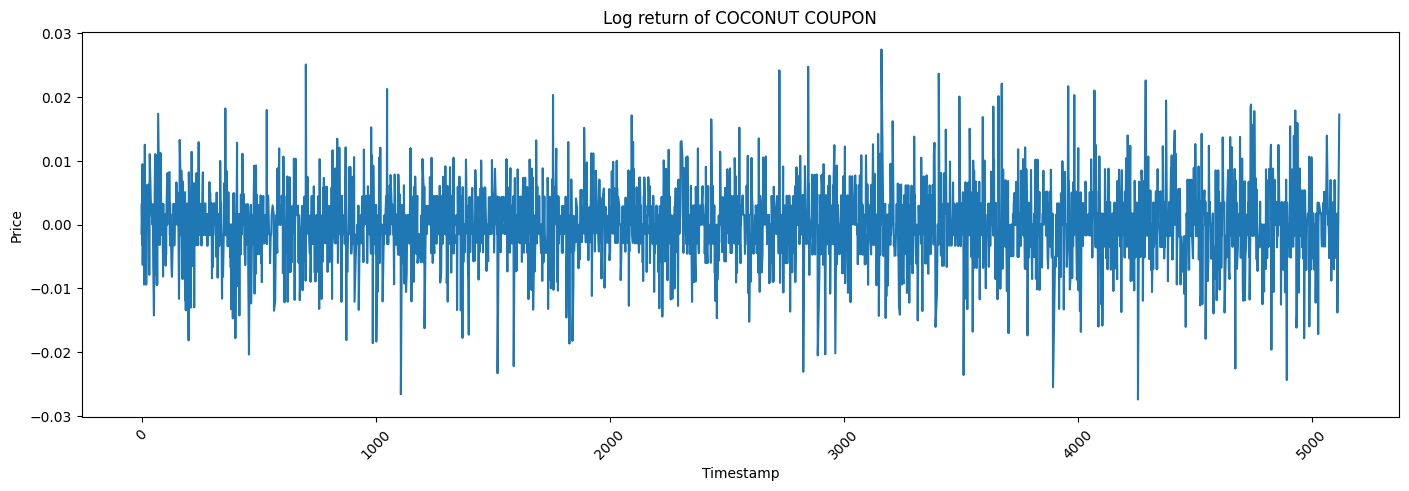

In [19]:
plt.figure(figsize=(17, 5))
# Plot the price
plt.plot(COCONUT_COUPON_returns)
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title("Log return of COCONUT COUPON")
plt.xticks(rotation=45)
plt.show()

In [20]:
merged_data = pd.merge(COCONUT_price, COCONUT_COUPON_price, on="timestamp", how="inner")
overlap_length = len(merged_data)  # price_x = STARFRUIT, price_y = AMETHYSTS
overlap_start_time = merged_data["timestamp"].iloc[0]
overlap_end_time = merged_data["timestamp"].iloc[-1]
print(overlap_length)
print(merged_data)
overlap_timestamps = merged_data["timestamp"]
print(overlap_start_time, overlap_end_time)

202
     timestamp  price_x  quantity_x  next_price  next_next_price  price_y  \
0        48100   9969.0           8      9964.0           9969.0    615.0   
1        88500   9949.0           9      9941.0           9943.0    593.0   
2       102400   9958.0           8      9955.0           9957.0    601.0   
3       102400   9958.0           8      9955.0           9957.0    601.0   
4       108500   9948.0           5      9966.0           9958.0    607.0   
..         ...      ...         ...         ...              ...      ...   
197     863630   9892.0           3      9894.0           9888.0    580.0   
198     868830   9885.0           9      9873.0           9872.0    564.0   
199     875630   9873.0           9      9872.0           9878.0    552.0   
200     934330   9878.0           8      9879.0           9882.0    569.0   
201     952130   9887.0           6      9897.0           9897.0    585.0   

     quantity_y  
0            10  
1            20  
2            15  

In [21]:
correlation = merged_data["price_x"].corr(merged_data["price_y"])
print("Correlation:", correlation)
score, pvalue, _ = coint(merged_data["price_x"], merged_data["price_y"])
print("pvalue: ", pvalue)
print("score: ", score)
print("Critial Values: ")
print("1%: ", _[0])
print("5%: ", _[1])
print("10%: ", _[2])

Correlation: 0.9557438376258951
pvalue:  1.0994858870106845e-05
score:  -5.604689632656981
Critial Values: 
1%:  -3.951756920373258
5%:  -3.366697389421054
10%:  -3.065617822578649


In [22]:
ratio = merged_data["price_x"] / merged_data["price_y"]

In [23]:
merged_data.head(10)

,timestamp,price_x,quantity_x,next_price,next_next_price,price_y,quantity_y
0,48100,9969.0,8,9964.0,9969.0,615.0,10
1,88500,9949.0,9,9941.0,9943.0,593.0,20
2,102400,9958.0,8,9955.0,9957.0,601.0,15
3,102400,9958.0,8,9955.0,9957.0,601.0,5
4,108500,9948.0,5,9966.0,9958.0,607.0,11
5,159900,9971.0,8,9973.0,9979.0,601.0,10
6,175000,9978.0,5,9980.0,9975.0,598.0,15
7,185500,9971.0,7,9976.0,9978.0,604.0,6
8,234600,9957.0,8,9961.0,9957.0,619.0,10
9,254900,9956.0,5,9956.0,9958.0,631.0,14


In [24]:
ratio

0      16.209756
1      16.777403
2      16.569052
3      16.569052
4      16.388797
         ...    
197    17.055172
198    17.526596
199    17.885870
200    17.360281
201    16.900855
Length: 202, dtype: float64

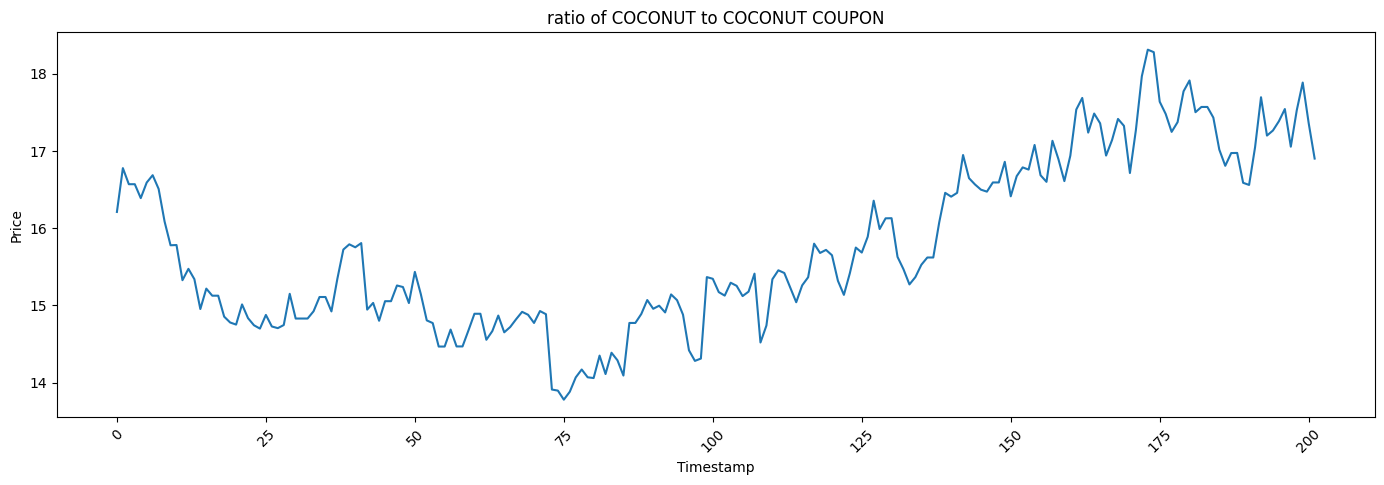

In [25]:
plt.figure(figsize=(17, 5))
# Plot the price
plt.plot(ratio)
plt.xlabel("Timestamp")
plt.ylabel("Price")
plt.title("ratio of COCONUT to COCONUT COUPON")
plt.xticks(rotation=45)
plt.show()

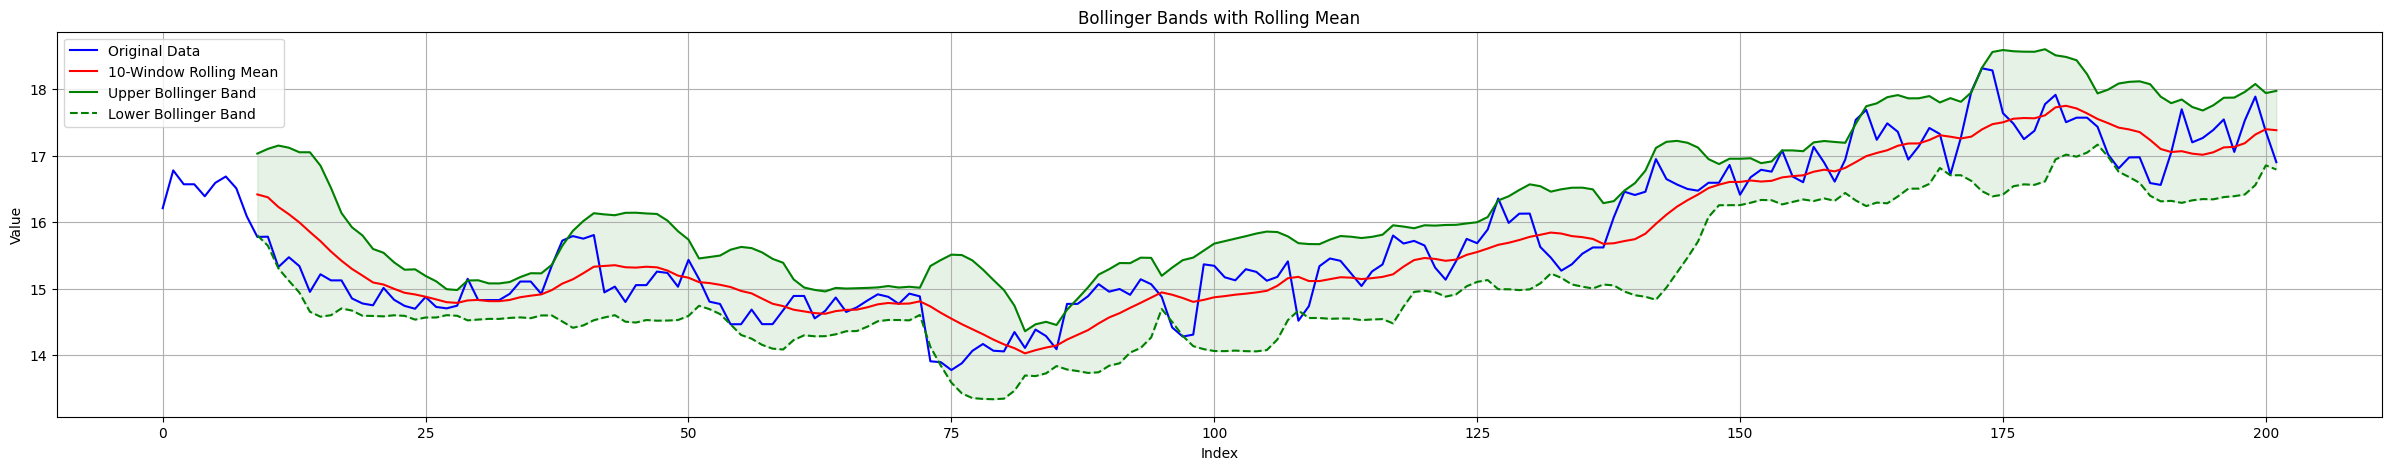

In [26]:
rolling_mean = ratio.rolling(window=10).mean()
rolling_std = ratio.rolling(window=10).std()

# Calculate Bollinger Bands
upper_band = rolling_mean + (rolling_std * 2)
lower_band = rolling_mean - (rolling_std * 2)

# Plotting
plt.figure(figsize=(30, 5))
plt.plot(ratio, label="Original Data", color="blue")
plt.plot(rolling_mean, label="10-Window Rolling Mean", color="red")
plt.plot(upper_band, label="Upper Bollinger Band", color="green")
plt.plot(lower_band, label="Lower Bollinger Band", color="green", linestyle="--")
plt.fill_between(ratio.index, lower_band, upper_band, color="green", alpha=0.1)
plt.title("Bollinger Bands with Rolling Mean")
plt.xlabel("Index")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
merged_data

,timestamp,price_x,quantity_x,next_price,next_next_price,price_y,quantity_y
0,48100,9969.0,8,9964.0,9969.0,615.0,10
1,88500,9949.0,9,9941.0,9943.0,593.0,20
2,102400,9958.0,8,9955.0,9957.0,601.0,15
3,102400,9958.0,8,9955.0,9957.0,601.0,5
4,108500,9948.0,5,9966.0,9958.0,607.0,11
...,...,...,...,...,...,...,...
197,863630,9892.0,3,9894.0,9888.0,580.0,17
198,868830,9885.0,9,9873.0,9872.0,564.0,17
199,875630,9873.0,9,9872.0,9878.0,552.0,12
200,934330,9878.0,8,9879.0,9882.0,569.0,19


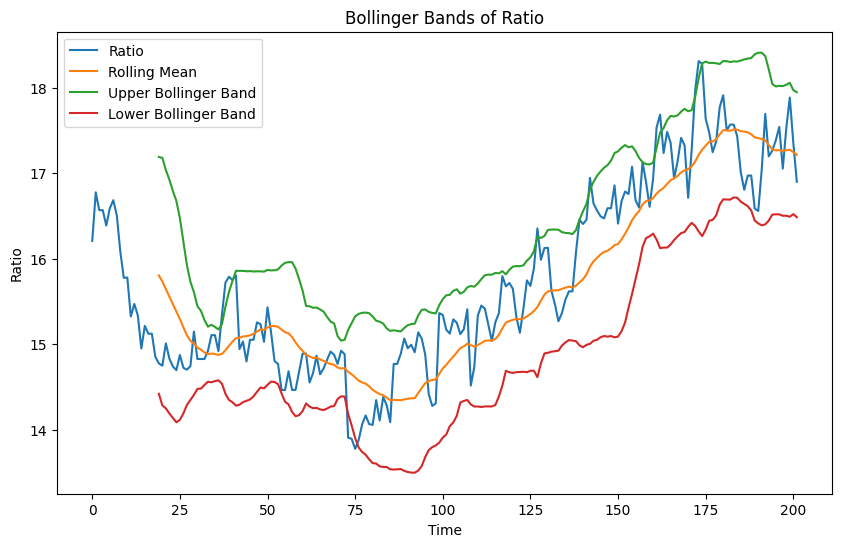

In [28]:
ratio = (
    merged_data["price_x"] / merged_data["price_y"]
)  # price_x = COCONUT, price_y = COCONUT_COUPON
period = 20
rolling_mean = ratio.rolling(window=period).mean()
rolling_std = ratio.rolling(window=period).std()
upper_band = rolling_mean + (2 * rolling_std)
lower_band = rolling_mean - (2 * rolling_std)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ratio, label="Ratio")
ax.plot(rolling_mean, label="Rolling Mean")
ax.plot(upper_band, label="Upper Bollinger Band")
ax.plot(lower_band, label="Lower Bollinger Band")
ax.legend()
plt.xlabel("Time")
plt.ylabel("Ratio")
plt.title("Bollinger Bands of Ratio")
plt.show()

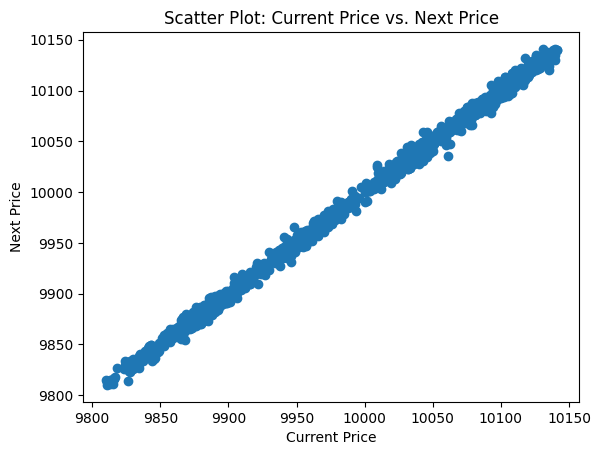

In [29]:
plt.scatter(COCONUT_df_copy["price"], COCONUT_df_copy["next_price"])
plt.xlabel("Current Price")
plt.ylabel("Next Price")
plt.title("Scatter Plot: Current Price vs. Next Price")
plt.show()

In [30]:
def mean_reversion_strategy(df, window=15, z_entry_threshold=1, z_exit_threshold=0):
    # Assuming 'merged' DataFrame has columns 'price_x' and 'price_y'
    # Calculate the ratio of price_x to price_y
    df["ratio"] = df["price_x"] / df["price_y"]

    # Calculate the moving average and moving standard deviation of the ratio
    df["ratio_ma"] = df["ratio"].rolling(window=window).mean()
    df["ratio_std"] = df["ratio"].rolling(window=window).std()

    # Calculate the z-score of the ratio
    df["z_score"] = (df["ratio"] - df["ratio_ma"]) / df["ratio_std"]

    # Create signals based on z-score
    df["position"] = 0  # No position to start
    # Go long (buy) when the z-score is below negative threshold
    df.loc[df["z_score"] < -z_entry_threshold, "position"] = 1
    # Go short (sell) when the z-score is above positive threshold
    df.loc[df["z_score"] > z_entry_threshold, "position"] = -1
    # Exit positions when the z-score crosses the exit threshold
    df.loc[df["z_score"] * df["position"] > z_exit_threshold, "position"] = 0

    # Forward fill the positions (as you keep position until a signal change)
    df["position"] = df["position"].ffill()

    return df


# Using the strategy on your 'merged' DataFrame
merged_data_with_signals = mean_reversion_strategy(
    merged_data, window=7, z_entry_threshold=1, z_exit_threshold=0
)

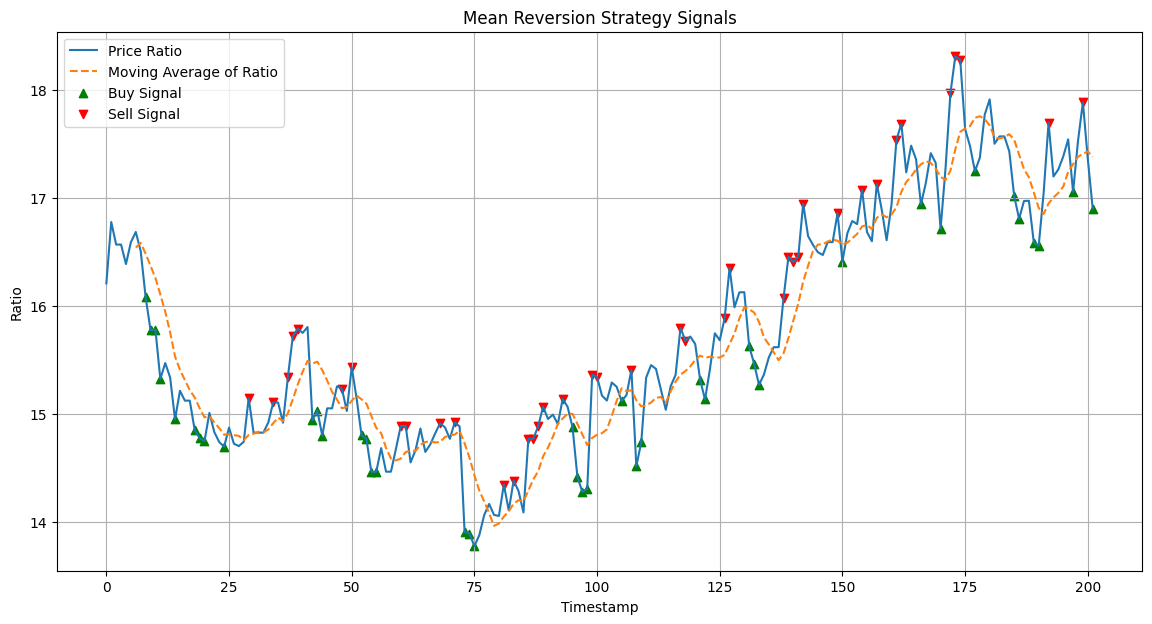

In [31]:
plt.figure(figsize=(14, 7))
plt.plot(
    merged_data_with_signals.index,
    merged_data_with_signals["ratio"],
    label="Price Ratio",
)

# Plot the moving average of the ratio
plt.plot(
    merged_data_with_signals.index,
    merged_data_with_signals["ratio_ma"],
    label="Moving Average of Ratio",
    linestyle="--",
)

# Highlight the buy signals
plt.scatter(
    merged_data_with_signals.index[merged_data_with_signals["position"] == 1],
    merged_data_with_signals["ratio"][merged_data_with_signals["position"] == 1],
    label="Buy Signal",
    marker="^",
    color="g",
    alpha=1,
)

# Highlight the sell signals
plt.scatter(
    merged_data_with_signals.index[merged_data_with_signals["position"] == -1],
    merged_data_with_signals["ratio"][merged_data_with_signals["position"] == -1],
    label="Sell Signal",
    marker="v",
    color="r",
    alpha=1,
)

plt.title("Mean Reversion Strategy Signals")
plt.xlabel("Timestamp")
plt.ylabel("Ratio")
plt.legend()
plt.grid(True)
plt.show()

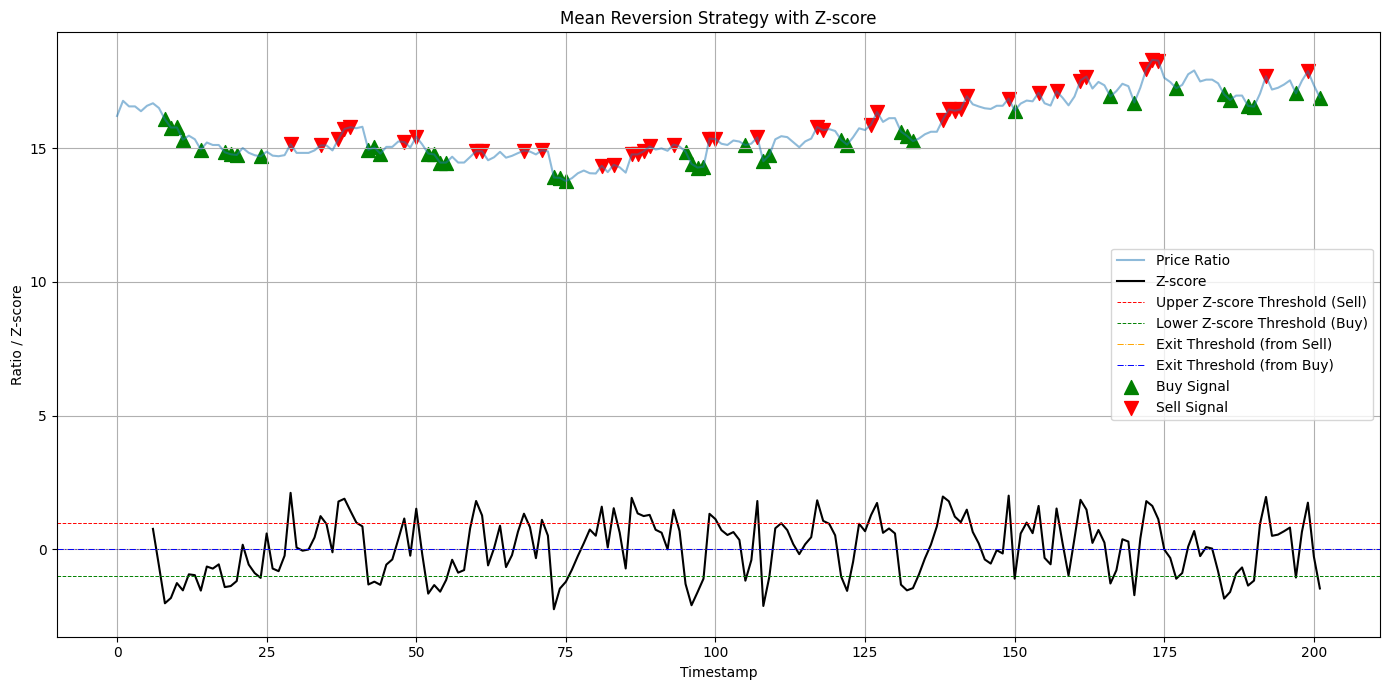

In [32]:
def plot_signals(df, z_entry_threshold, z_exit_threshold):
    # Plot the price ratio
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df["ratio"], label="Price Ratio", alpha=0.5)

    # Plot the z-score
    plt.plot(df.index, df["z_score"], label="Z-score", color="black")

    # Plot horizontal lines for entry and exit thresholds
    plt.axhline(
        z_entry_threshold,
        color="red",
        linestyle="--",
        linewidth=0.7,
        label="Upper Z-score Threshold (Sell)",
    )
    plt.axhline(
        -z_entry_threshold,
        color="green",
        linestyle="--",
        linewidth=0.7,
        label="Lower Z-score Threshold (Buy)",
    )
    plt.axhline(
        z_exit_threshold,
        color="orange",
        linestyle="-.",
        linewidth=0.7,
        label="Exit Threshold (from Sell)",
    )
    plt.axhline(
        -z_exit_threshold,
        color="blue",
        linestyle="-.",
        linewidth=0.7,
        label="Exit Threshold (from Buy)",
    )

    # Highlight the buy signals
    plt.scatter(
        df.index[df["position"] == 1],
        df["ratio"][df["position"] == 1],
        label="Buy Signal",
        marker="^",
        color="g",
        s=100,
        alpha=1,
    )

    # Highlight the sell signals
    plt.scatter(
        df.index[df["position"] == -1],
        df["ratio"][df["position"] == -1],
        label="Sell Signal",
        marker="v",
        color="r",
        s=100,
        alpha=1,
    )

    plt.title("Mean Reversion Strategy with Z-score")
    plt.xlabel("Timestamp")
    plt.ylabel("Ratio / Z-score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Call the function with the entry and exit threshold values
plot_signals(merged_data_with_signals, z_entry_threshold=1, z_exit_threshold=0)

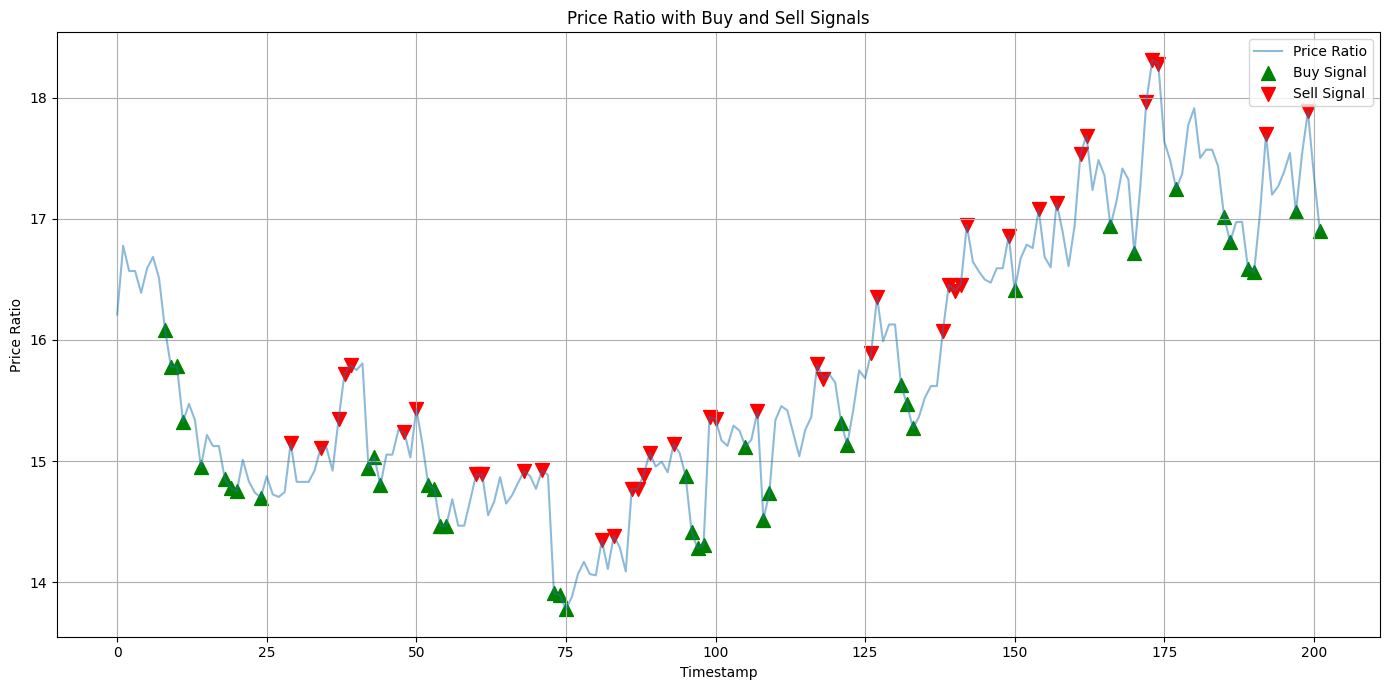

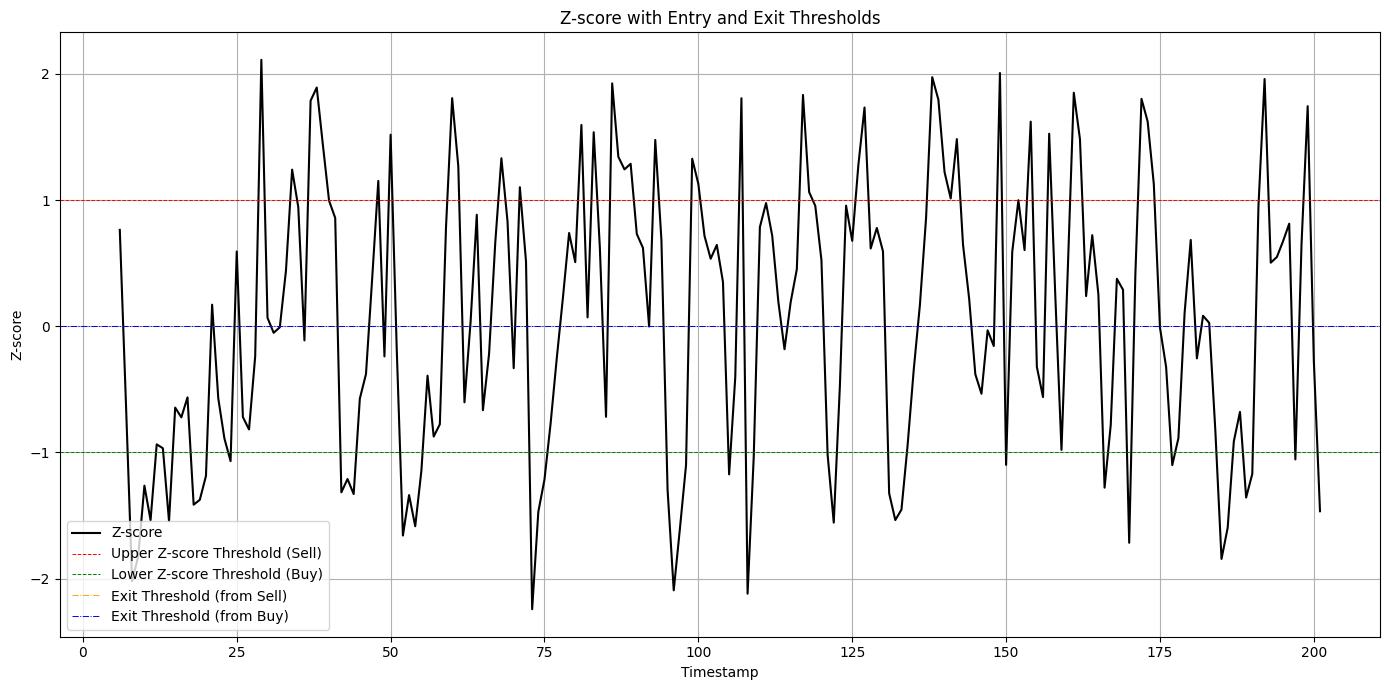

In [33]:
import matplotlib.pyplot as plt


def plot_signals(df, z_entry_threshold, z_exit_threshold):
    # Plot the price ratio
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df["ratio"], label="Price Ratio", alpha=0.5)

    # Highlight the buy and sell signals on the ratio plot
    plt.scatter(
        df.index[df["position"] == 1],
        df["ratio"][df["position"] == 1],
        label="Buy Signal",
        marker="^",
        color="g",
        s=100,
        alpha=1,
    )
    plt.scatter(
        df.index[df["position"] == -1],
        df["ratio"][df["position"] == -1],
        label="Sell Signal",
        marker="v",
        color="r",
        s=100,
        alpha=1,
    )

    plt.title("Price Ratio with Buy and Sell Signals")
    plt.xlabel("Timestamp")
    plt.ylabel("Price Ratio")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plot the z-score with thresholds
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df["z_score"], label="Z-score", color="black")

    # Plot horizontal lines for entry and exit thresholds
    plt.axhline(
        z_entry_threshold,
        color="red",
        linestyle="--",
        linewidth=0.7,
        label="Upper Z-score Threshold (Sell)",
    )
    plt.axhline(
        -z_entry_threshold,
        color="green",
        linestyle="--",
        linewidth=0.7,
        label="Lower Z-score Threshold (Buy)",
    )
    plt.axhline(
        z_exit_threshold,
        color="orange",
        linestyle="-.",
        linewidth=0.7,
        label="Exit Threshold (from Sell)",
    )
    plt.axhline(
        -z_exit_threshold,
        color="blue",
        linestyle="-.",
        linewidth=0.7,
        label="Exit Threshold (from Buy)",
    )

    plt.title("Z-score with Entry and Exit Thresholds")
    plt.xlabel("Timestamp")
    plt.ylabel("Z-score")
    plt.legend(loc="best")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


# Call the function with the dataframe and threshold values
plot_signals(merged_data_with_signals, z_entry_threshold=1, z_exit_threshold=0)

In [34]:
PRODUCTS_COCONUT = [
    "COCONUT",
]
past_prices = dict()

past_prices = {
    product: pd.DataFrame(columns=["Price", "MTSI", "Signal", "Buy", "Sell"])
    for product in PRODUCTS_COCONUT
}

In [35]:
past_prices

{'COCONUT': Empty DataFrame
 Columns: [Price, MTSI, Signal, Buy, Sell]
 Index: []}

In [36]:
past_prices = {
    product: pd.DataFrame(
        columns=[
            "Price",
            "PC",
            "SPC",
            "DSPC",
            "APC",
            "SAPC",
            "DSAPC",
            "TSI",
            "MTSI",
            "Signal",
            "Buy",
            "Sell",
        ]
    )
    for product in [
        "COCONUT",
        "COCONUT_COUPON",
    ]
}

In [37]:
past_prices

{'COCONUT': Empty DataFrame
 Columns: [Price, PC, SPC, DSPC, APC, SAPC, DSAPC, TSI, MTSI, Signal, Buy, Sell]
 Index: [],
 'COCONUT_COUPON': Empty DataFrame
 Columns: [Price, PC, SPC, DSPC, APC, SAPC, DSAPC, TSI, MTSI, Signal, Buy, Sell]
 Index: []}

In [38]:
mtsi_params = {
    "COCONUT": (25, 13, 7),
    "COCONUT_COUPON": (
        25,
        13,
        7,
    ),
}

In [40]:
mtsi_params["COCONUT"]

(25, 13, 7)